In [1]:
# Run this cell just once on your machine
#!pip install s3fs

In [2]:
import json
import os
from matplotlib import pyplot as plt
import pandas as pd
import pickle
from s3fs.core import S3FileSystem
import numpy as np

c:\program files\python36\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\program files\python36\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\program files\python36\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
MODEL_DIR = "mids-capstone-irrigation-detection/models"

In [4]:
s3_file = S3FileSystem()

datasets = {
    "balanced": "Balanced Dataset",
    "expanded": "Balanced and with Extended Labels",
}

In [5]:
def f_scores(scores):
    precision = scores[6]
    recall = scores[7]
    if precision + recall == 0.0:
        return [0.0, 0.0]
    f1 = (2 * precision * recall) / (precision + recall)
    beta = 0.5
    f05 = ((1 + beta) * precision * recall) / (beta * precision + recall)
    return [f1, f05]
    
def plot_results(plot_df, title=None):
    _title = "Dataset Split Percent vs F1 Score"
    if title is not None:
        _title += f" - {title}"
    plot_df = plot_df.sort_values("split_percent")
    plot_df.plot(kind="bar", figsize=(15,12), rot=0, ylim=(0.0, 1.0), fontsize=12, x='split_percent', y='f1',color='b')
    
    plt.title(_title, fontsize=22)
    plt.legend(fontsize=12)
    plt.xlabel("F1 Score", fontsize=18)
    plt.ylabel("Split Percent", fontsize=18)

def display_results(df = None):
    if df is None:
        df = load_results()
    for dataset, desc in datasets.items():
        _df = df[df.dataset == dataset]
        
        line = "=" * len(desc) + "=="
        print(f"\n\n{line}\n {desc}\n{line}")
        display(_df.sort_values("split_percent"))

        plot_results(_df, desc)
        plt.savefig(f"{dataset}.png")
        

In [6]:
def load_finetune_results() :
    data = []
    files = s3_file.glob(MODEL_DIR+"/BEN_finetune/*.json")
    #print([x.split('/')[-1] for x in files])
    
    for f in files :
        r=json.load(s3_file.open(f))
        dataset,percent = f.split('/')[-1].split('_')[0:2]
        #print(dataset,percent, r['score'])
        
        score = [dataset, int(percent)] + r["score"] + f_scores(r["score"])
        data.append(score)
    
    df = pd.DataFrame(data)
    df.columns = ["dataset","split_percent","loss","tp","fp","tn","fn","accuracy","precision","recall","auc","f1","f0.5"]
    df.split_percent = pd.to_numeric(df.split_percent, errors='coerce')
    return df



 Balanced Dataset


,dataset,split_percent,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,f1,f0.5
2,balanced,1,0.601744,1736.0,718.0,1313.0,297.0,0.750246,0.707416,0.853911,0.799443,0.773791,0.750324
4,balanced,3,0.468172,1602.0,472.0,1560.0,430.0,0.778051,0.772420,0.788386,0.864622,0.780321,0.777670
1,balanced,10,0.414822,1773.0,538.0,1492.0,261.0,0.803396,0.767200,0.871681,0.882509,0.816110,0.799129
3,balanced,25,0.429256,1755.0,500.0,1531.0,278.0,0.808563,0.778270,0.863256,0.880372,0.818563,0.804677
5,balanced,50,0.420994,1685.0,414.0,1618.0,347.0,0.812746,0.802763,0.829232,0.890809,0.815783,0.811396
0,balanced,100,0.394389,1889.0,554.0,1479.0,142.0,0.828740,0.773230,0.930084,0.895239,0.844435,0.819286




 Balanced and with Extended Labels


,dataset,split_percent,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,f1,f0.5
8,expanded,1,0.632764,4655.0,1811.0,3677.0,833.0,0.759111,0.719920,0.848214,0.815952,0.778819,0.758143
10,expanded,3,0.507432,5027.0,2054.0,3437.0,458.0,0.771137,0.709928,0.916500,0.831861,0.800095,0.767598
7,expanded,10,0.482517,4336.0,1408.0,4084.0,1148.0,0.767128,0.754875,0.790664,0.841841,0.772355,0.766439
9,expanded,25,0.467871,4880.0,1690.0,3795.0,611.0,0.790361,0.742770,0.888727,0.855676,0.809220,0.785787
11,expanded,50,0.474145,4275.0,1234.0,4255.0,1212.0,0.777150,0.776003,0.779114,0.854385,0.777555,0.777037
6,expanded,100,0.459749,5007.0,1836.0,3652.0,481.0,0.788903,0.731697,0.912354,0.860625,0.812100,0.783405


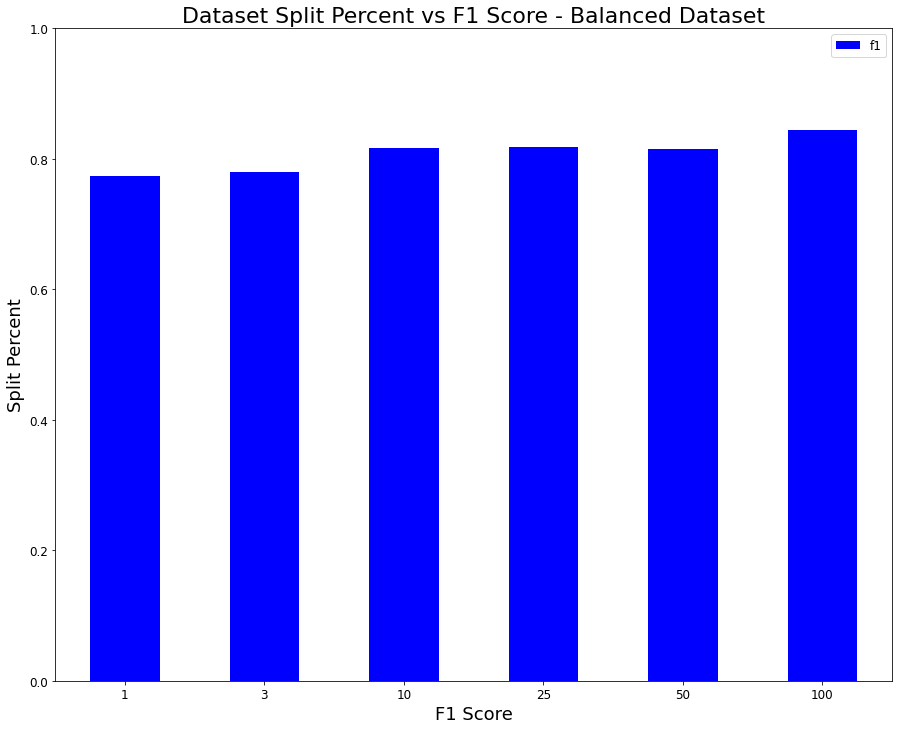

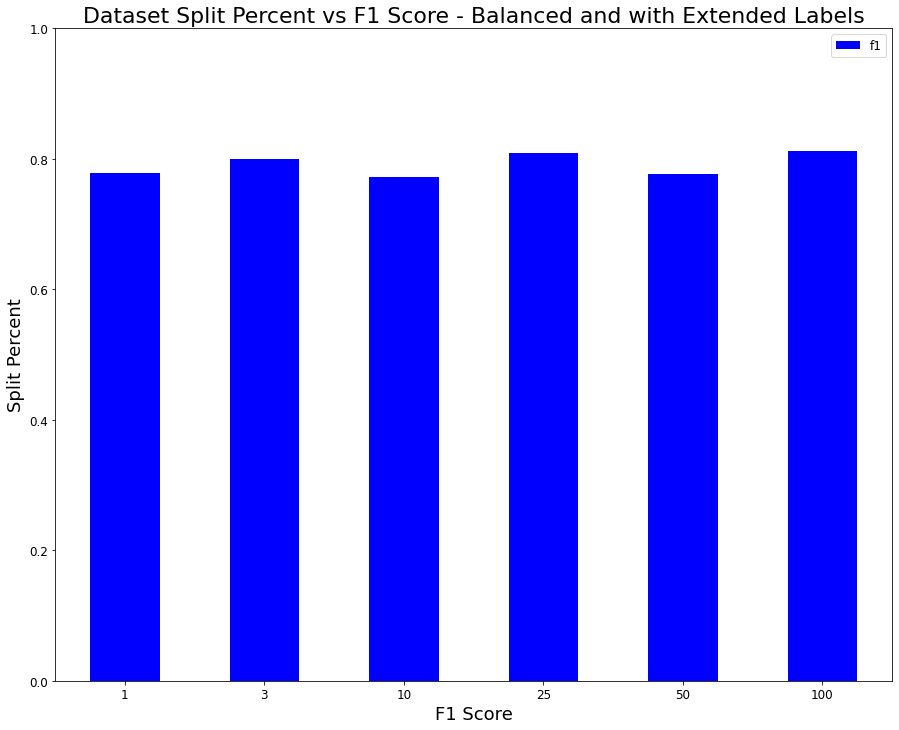

In [7]:
df = load_finetune_results()
display_results(df)

In [8]:
def f_scores2(scores):
    precision = scores['precision']
    recall = scores['recall']
    if precision + recall == 0.0:
        return [0.0, 0.0]
    f1 = (2 * precision * recall) / (precision + recall)
    beta = 0.5
    f05 = ((1 + beta) * precision * recall) / (beta * precision + recall)
    return [f1, f05]
    

In [9]:
def load_distill_results() :
    data = []
    files = s3_file.glob(MODEL_DIR+"/BEN_distill/*.pkl")
    #print([x.split('/')[-1] for x in files])
    
    for f in files :
        r=pd.read_pickle(s3_file.open(f))
        f_split = f.split('/')[-1].split('.')[0].split('_')
        
        dataset = f_split[0]
        percent = f_split[1]
        arch = f_split[-1]
        
        score = [dataset, int(percent), arch] + f_scores(r["student"])
        data.append(score)
    
    df = pd.DataFrame(data)
    df.columns = ["dataset","split_percent","arch","f1","f0.5"]
    df.split_percent = pd.to_numeric(df.split_percent, errors='coerce')
    return df

In [10]:
distill_df = load_distill_results()



 Balanced Dataset


,dataset,split_percent,arch,f1,f0.5
14,balanced,1,Xception,0.771703,0.748485
13,balanced,1,ResNet50,0.766372,0.741333
12,balanced,1,ResNet152,0.764931,0.744189
10,balanced,1,InceptionV3,0.771052,0.748050
11,balanced,1,ResNet101V2,0.772383,0.748920
22,balanced,3,ResNet152,0.753126,0.752327
20,balanced,3,InceptionV3,0.776229,0.774398
23,balanced,3,ResNet50,0.778592,0.776821
24,balanced,3,Xception,0.780107,0.777832
21,balanced,3,ResNet101V2,0.767171,0.769269




 Balanced and with Extended Labels


,dataset,split_percent,arch,f1,f0.5
44,expanded,1,Xception,0.778873,0.758134
43,expanded,1,ResNet50,0.778029,0.757500
42,expanded,1,ResNet152,0.764126,0.739861
40,expanded,1,InceptionV3,0.777359,0.757270
41,expanded,1,ResNet101V2,0.779995,0.758854
52,expanded,3,ResNet152,0.800830,0.768956
50,expanded,3,InceptionV3,0.799968,0.767148
53,expanded,3,ResNet50,0.800064,0.767318
54,expanded,3,Xception,0.800064,0.767634
51,expanded,3,ResNet101V2,0.797371,0.764114


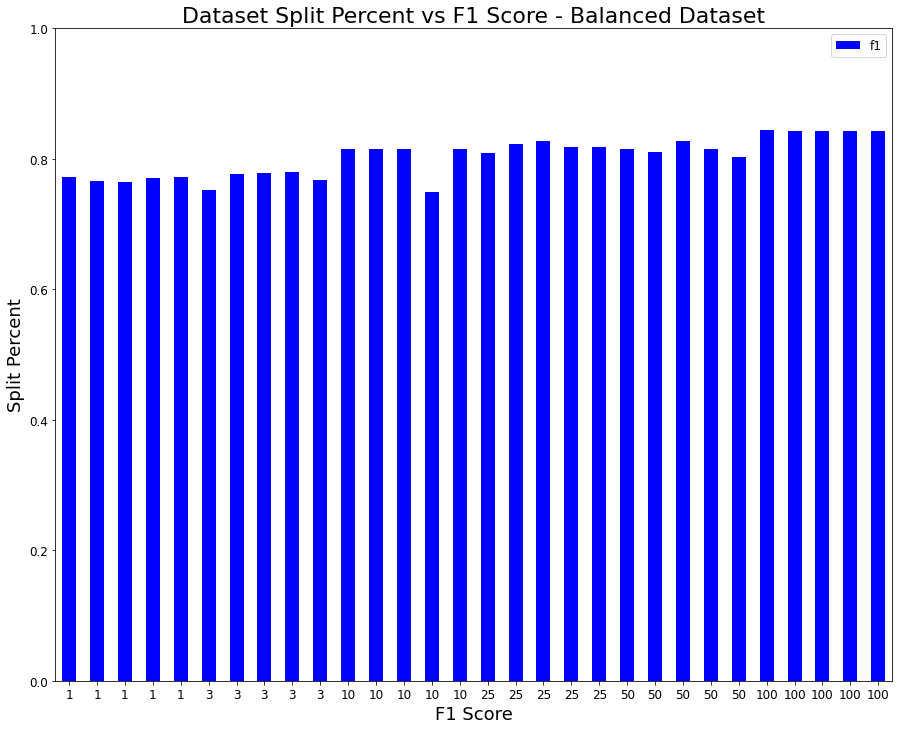

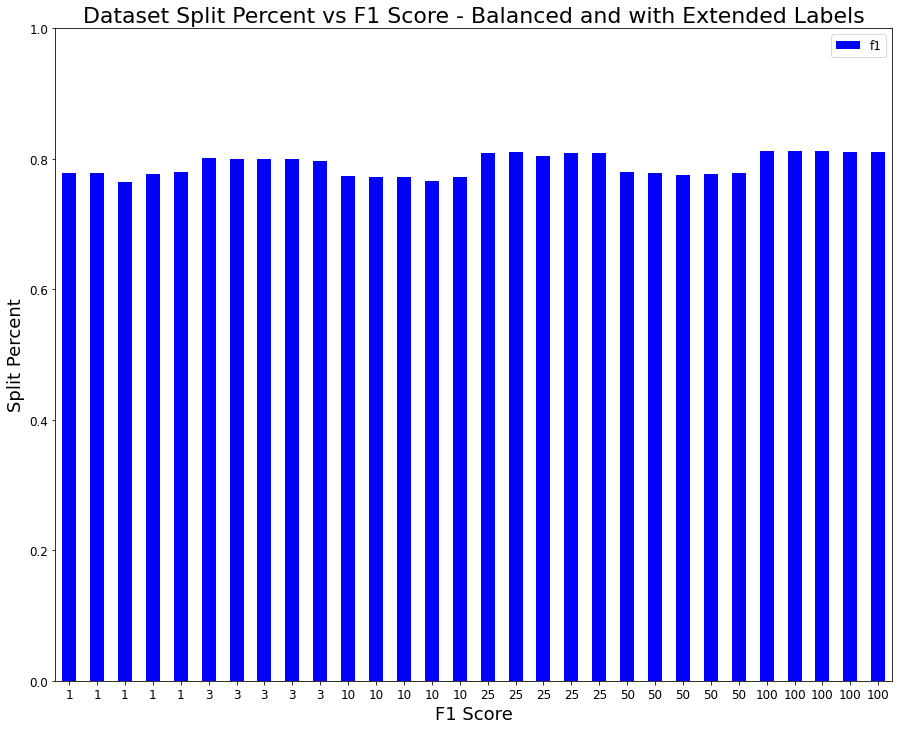

In [11]:
display_results(distill_df)



 Balanced Dataset


,dataset,split_percent,arch,f1,f0.5
13,balanced,1,ResNet50,0.766372,0.741333
23,balanced,3,ResNet50,0.778592,0.776821
8,balanced,10,ResNet50,0.814968,0.796917
18,balanced,25,ResNet50,0.817823,0.802368
28,balanced,50,ResNet50,0.803130,0.801497
3,balanced,100,ResNet50,0.842129,0.817393




 Balanced and with Extended Labels


,dataset,split_percent,arch,f1,f0.5
43,expanded,1,ResNet50,0.778029,0.757500
53,expanded,3,ResNet50,0.800064,0.767318
38,expanded,10,ResNet50,0.771886,0.765935
48,expanded,25,ResNet50,0.808620,0.785822
58,expanded,50,ResNet50,0.777697,0.777367
33,expanded,100,ResNet50,0.812829,0.783654


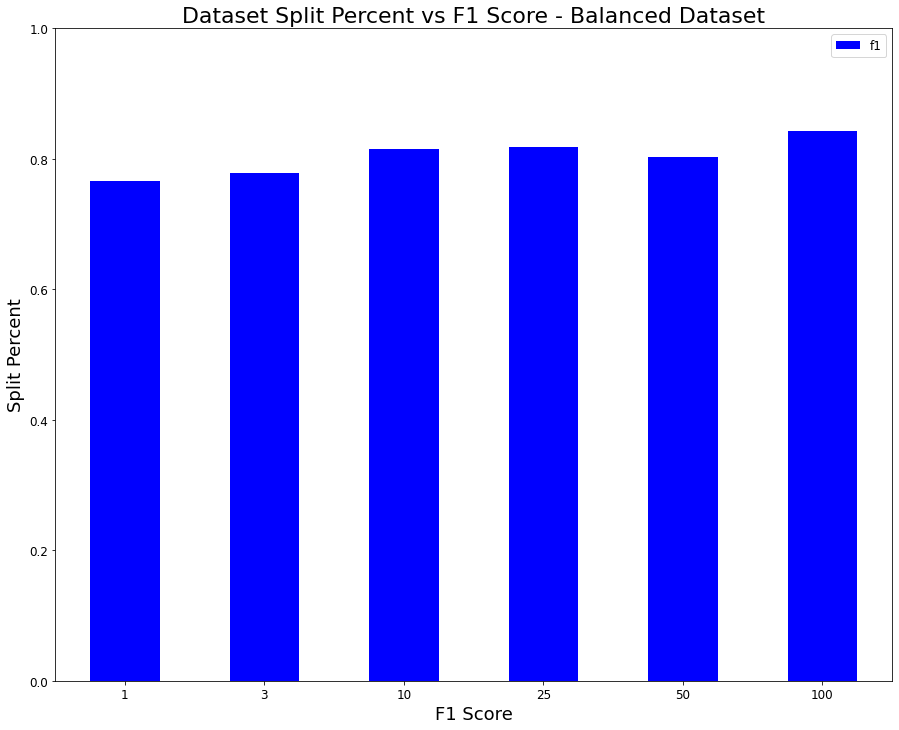

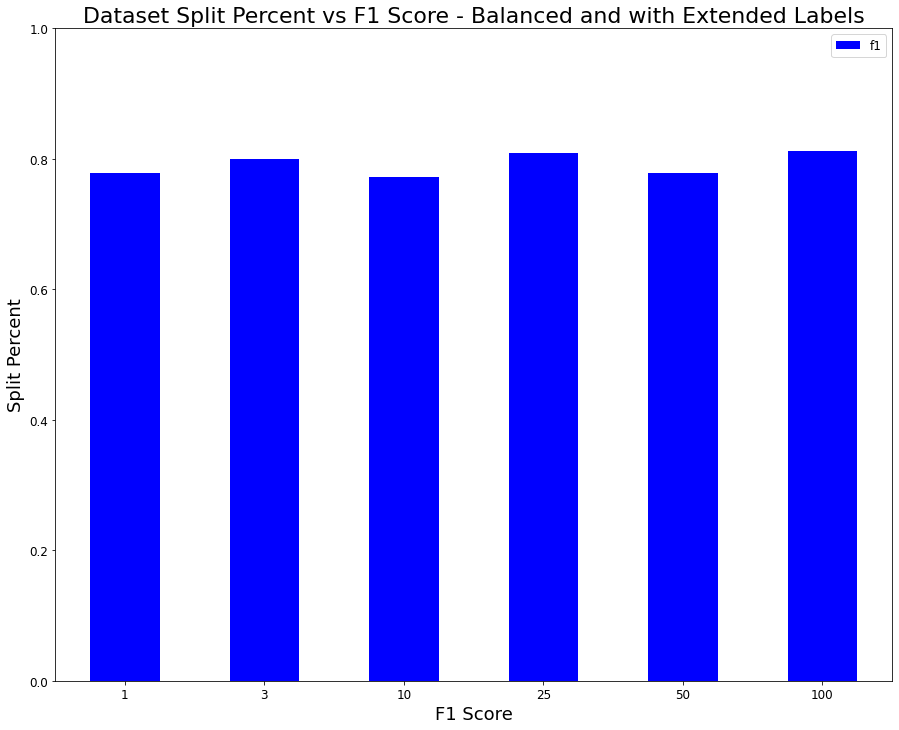

In [12]:
# Just ResNet50
display_results(distill_df[distill_df.arch == "ResNet50"])